# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib inline
import pandas as pd
import tqdm
import numpy as np
from skimage.filters import threshold_otsu
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import glob

In [3]:
def palm_hist(df, yx_shape, subsampling=1):
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    return np.histogramdd(df[["y0", "x0"]].values, bins=bins)[0]

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [178]:
def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    if len(fiducials_df) == 1:
        return remove_xy_mean(fiducials_df[0])
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.x0.plot(ax=ax0)
            ff.y0.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        df_means[["x0", "y0", "z0"]] = df_means[["x0", "y0", "z0"]].mul(df_means[weighted], "index")
        temp = df_means.groupby("frame")
        return temp[["x0", "y0", "z0"]].sum().div(temp[weighted].sum(), "index")
    else:
        return df_means.groupby("frame")[["x0", "y0", "z0"]].mean()

def remove_drift(df_data, drift):
    # make our index frame number so that when we subtract drift it aligns automatically along
    # the index, this needs to be tested.
    # this also, conveniently, makes a copy of the data
    df_data_dc = df_data.set_index("frame")
    # subtract drift only (assumes that drift only has these keys)
    df_data_dc[["x0", "y0", "z0"]] -= drift
    # return the data frame with the index reset so that all localizations have
    # a unique id
    return df_data_dc.reset_index()

In [5]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["x0", "y0","z0", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift", "zdrift"]] = pd.DataFrame([f.agg({"x0":fwhm,"y0":fwhm, "z0":fwhm}) for
                                                    f in fid_df_list])[["x0","y0", "z0"]]
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["x0","y0", "z0"]] - f[["x0","y0", "z0"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, blobs, radius, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.x0 - x) ** 2 + (df.y0 - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('frame').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [6]:
def plot_stats(fids_df):
    fid, drift = calc_fiducial_stats(fids_df)
    fid[["x0", "xdrift", "y0", "ydrift", "sigma"]] *= 130
    fid[["z0", "zdrift"]] *= 20
    fid.sort_values("sigma").reset_index().plot(subplots=True)
    fid.hist(bins=32)
    drift.hist(bins=64, normed=True, layout=(3,1), figsize=(3, 9))
#     pd.plotting.table(plt.gca(), np.round(drift.describe(), 2), loc='upper right', colWidths=[0.2, 0.2, 0.2])
    print(drift.std() * 2 * np.sqrt(2 * np.log(2)))

In [68]:
data_dict = {path:pd.read_hdf(path, "raw_fits") for path in glob.iglob("Localizations/*.h5")}

In [9]:
zcalib = pd.read_hdf("z_calib3_unweighted.h5", "psf_nb/mle/win19")

In [10]:
def find_real_roots_near_zero(poly):
    # convert array-like to poly
    poly = np.poly1d(poly)
    r = poly.roots
    r = r[~np.iscomplex(r)].real
    r.sort()
    i = np.abs(r).argmin()
    r1 = r[i]
    if r1 < 0:
        return r[i:i + 2]
    else:
        return r[i - 1:i + 1]

In [11]:
from scipy.interpolate import interp1d

In [12]:
from dphplotting import display_grid

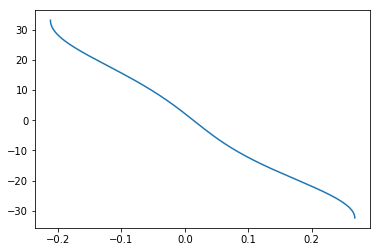

In [13]:
# make ellip to z from polynomial fit of z to ellip
poly1d = np.poly1d(zcalib.ellip)
xmin, xmax = find_real_roots_near_zero(poly1d.deriv())
x = np.linspace(xmin, xmax, 1024)
y = poly1d(x)
plt.plot(y, x)
z_func = interp1d(y, x, bounds_error=False)

In [69]:
%%time
# jury-rigged
for k, v in data_dict.items():
    if "z0" not in v.columns:
        %time v["z0"] = z_func(v["sigma_x"] - v["sigma_y"]) / (v["sigma_x"] + v["sigma_y"])
    %time v.dropna(inplace=True)

Wall time: 1.68 s
Wall time: 5.66 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.04 s
Wall time: 7.07 s
Wall time: 3.98 s
Wall time: 3.64 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.07 s
Wall time: 6.95 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.05 s
Wall time: 6.92 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.01 s
Wall time: 6.96 s
Wall time: 3.84 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.11 s
Wall time: 7.5 s
Wall time: 3.59 s
Wall time: 3.6 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.03 s
Wall time: 6.88 s


C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Wall time: 1.03 s
Wall time: 6.91 s
Wall time: 1min 22s


In [70]:
# filter z
for k, v in data_dict.items():
    data_dict[k] = v[abs(v.z0) < 30]

In [71]:
%time hists = {k:palm_hist(v, (512, 512)) for k, v in data_dict.items()}

Wall time: 36.3 s


(<matplotlib.figure.Figure at 0x258d37fafd0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000258D2760278>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x0000025AD9B1F8D0>]], dtype=object))

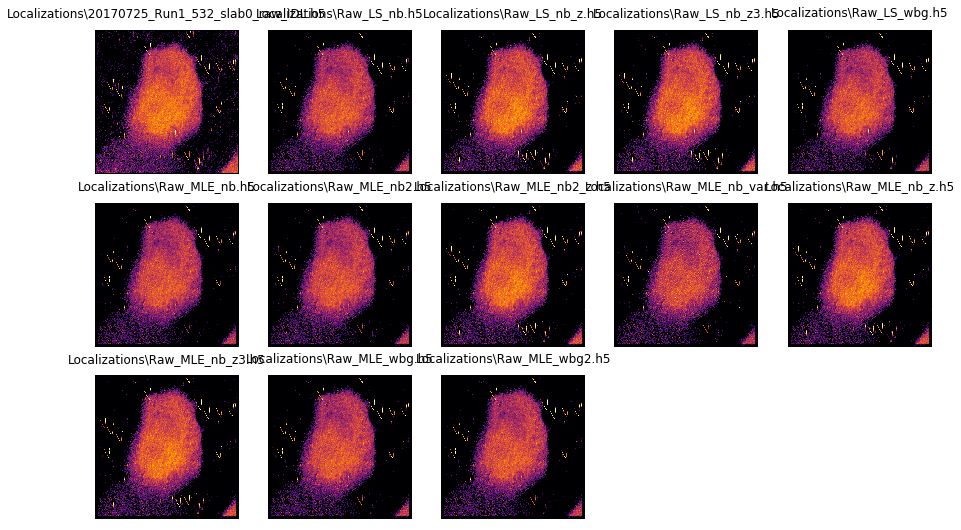

In [72]:
display_grid(hists, cmap="inferno", norm=PowerNorm(0.25), vmax=1000)

In [179]:
pf = PeakFinder(hists["Localizations\\Raw_LS_nb.h5"], 20, 200)

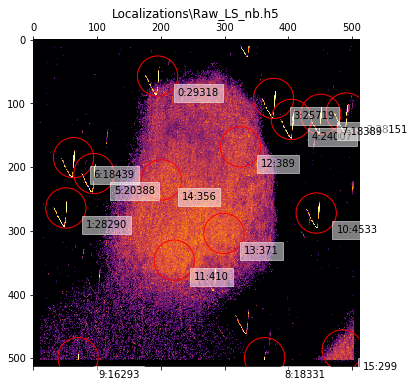

In [180]:
pf.find_blobs()
pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.25), vmax=1000)
plt.title(k)

In [181]:
initial_fid = extract_fiducials(data_dict[k], [pf.blobs[1, :2]], 40)

A Jupyter Widget

In [182]:
initial_drift = calc_drift(initial_fid)

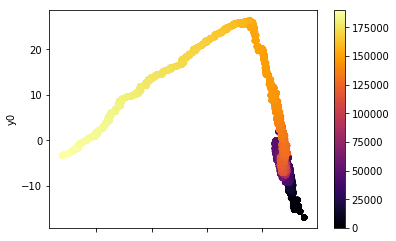

In [183]:
initial_drift.plot.scatter("x0","y0", c=np.arange(len(initial_drift)), cmap="inferno")

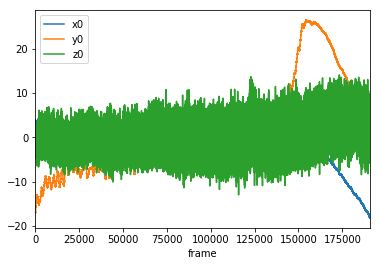

In [184]:
initial_drift[["x0", "y0", "z0"]].plot()

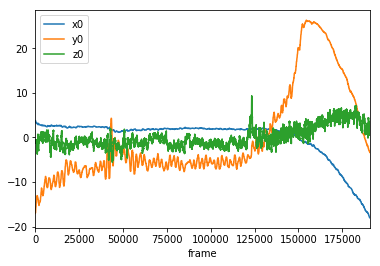

In [185]:
initial_drift2 = initial_drift[["x0", "y0", "z0"]].rolling(100, 0, center=True).mean()
initial_drift2.plot()

In [186]:
data_dc = {k:remove_drift(v, initial_drift2) for k, v in tqdm.tqdm_notebook(data_dict.items())}

A Jupyter Widget

In [187]:
hists_dc = {k:palm_hist(v, (512, 512)) for k, v in tqdm.tqdm_notebook(data_dc.items())}

A Jupyter Widget

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


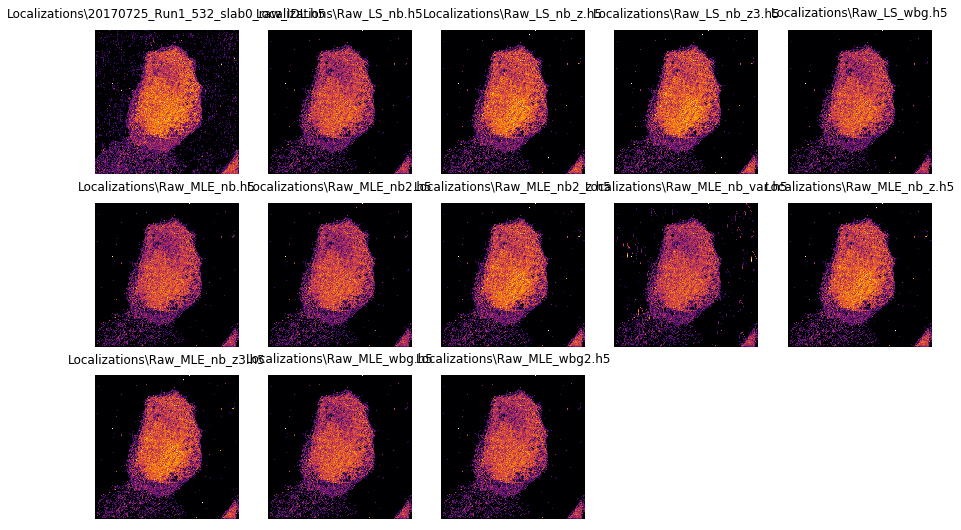

In [188]:
display_grid(hists_dc, cmap="inferno", norm=PowerNorm(0.25), vmax=1000);

In [189]:
def find_fiducials(df, yx_shape, subsampling=1):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.frame.max() - df.frame.min()
    hist_2d = palm_hist(df, yx_shape, subsampling)
    pf = PeakFinder(hist_2d, 1)
    pf.blob_sigma = 1/subsampling
    # no blobs found so try again with a lower threshold
    pf.thresh = 0
    pf.find_blobs()
    blob_thresh = max(threshold_otsu(pf.blobs[:, 3]), num_frames / 10)
    if not pf.blobs.size:
        # still no blobs then raise error
        raise RuntimeError("No blobs found!")
    pf.blobs = pf.blobs[pf.blobs[:,3] > blob_thresh]
    if pf.blobs[:, 3].max() < num_frames * subsampling / 2:
        print("Warning, drift maybe too high to find fiducials")
    # correct positions for subsampling
    pf.blobs[:, :2] = pf.blobs[:, :2] * subsampling
    return pf

In [190]:
k = "Localizations\\Raw_LS_nb.h5"
v = data_dc[k]
test_fid = find_fiducials(v, (512, 512), 1)

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


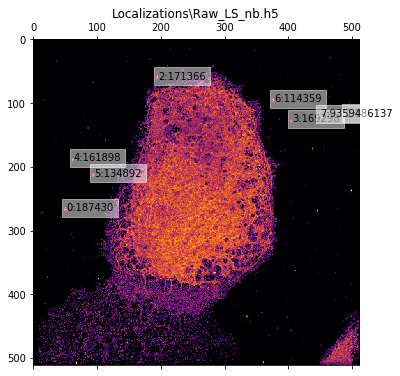

In [191]:
test_fid.plot_blobs(cmap="inferno", norm=PowerNorm(0.25), vmax=1000)
plt.title(k)

In [192]:
test_fid_df = extract_fiducials(v, test_fid.blobs[:,:2], 2)

A Jupyter Widget

x0    0.143117
y0    0.334026
z0    6.620629
dtype: float64


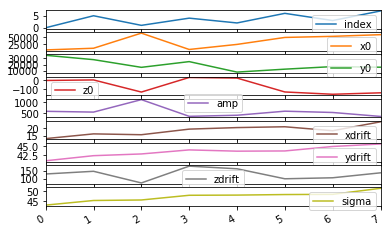

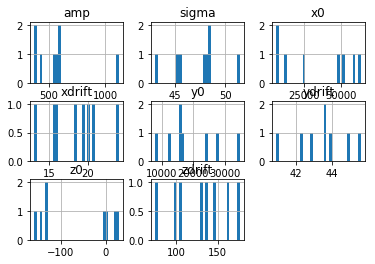

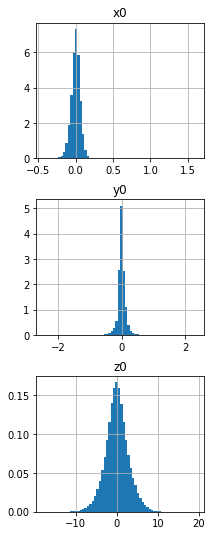

In [193]:
plot_stats(test_fid_df)

In [194]:
test_fid_stats, test_fid_drift = calc_fiducial_stats(test_fid_df)

'Localizations\\Raw_LS_nb.h5'

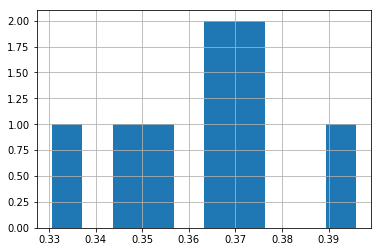

In [195]:
fig, ax = plt.subplots()
test_fid_stats.sigma.hist(ax=ax)
k

In [196]:
good_fid = test_fid_stats[test_fid_stats.sigma < 0.4]
len(good_fid)

8

In [197]:
good_fid.sort_values("x0")

,x0,y0,z0,amp,xdrift,ydrift,zdrift,sigma
0,49.850103,266.940651,-0.247440,598.270386,0.101139,0.314713,6.449318,0.330565
4,61.606935,189.349453,1.416172,372.256513,0.147969,0.337838,8.822734,0.368821
5,93.632517,213.455755,0.046521,562.750435,0.124474,0.325557,7.265272,0.348541
2,193.958755,60.639965,1.085255,420.669689,0.155597,0.335165,8.028449,0.369521
6,376.262693,96.481030,-6.628918,603.708437,0.159667,0.335620,4.995693,0.371664
3,404.859386,128.124667,-7.899692,545.163525,0.140075,0.345130,5.300260,0.372472
7,448.626548,120.492195,-7.098311,367.529234,0.184153,0.350471,6.800241,0.395907
1,489.118753,119.030760,-6.677343,1124.172613,0.120302,0.329243,3.735467,0.350533


In [198]:
for k, v in data_dc.items():
    v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12115703 entries, 0 to 12115702
Data columns (total 8 columns):
frame      int64
amp        float64
offset     float64
sigma_x    float64
sigma_y    float64
y0         float64
x0         float64
z0         float64
dtypes: float64(7), int64(1)
memory usage: 739.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7468529 entries, 0 to 7468528
Data columns (total 16 columns):
frame        int64
SNR          float64
amp          float64
amp_e        float64
noise        float64
offset       float64
offset_e     float64
sigma_x      float64
sigma_x_e    float64
sigma_y      float64
sigma_y_e    float64
x0           float64
x0_e         float64
y0           float64
y0_e         float64
z0           float64
dtypes: float64(15), int64(1)
memory usage: 911.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11736662 entries, 0 to 11736661
Data columns (total 13 columns):
frame       int64
SNR         float64
amp         float64
amp_e      

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

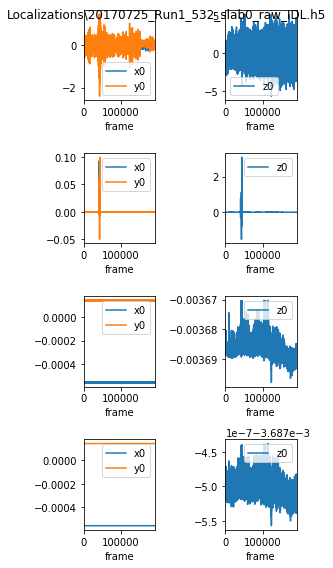

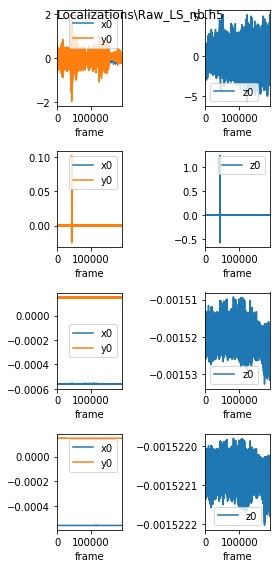

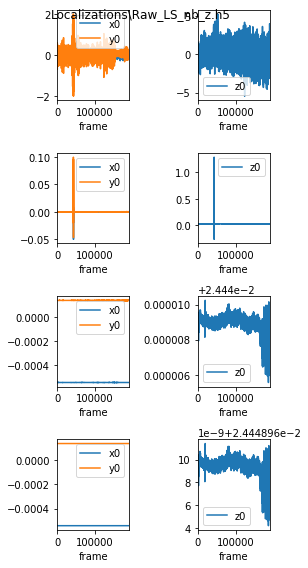

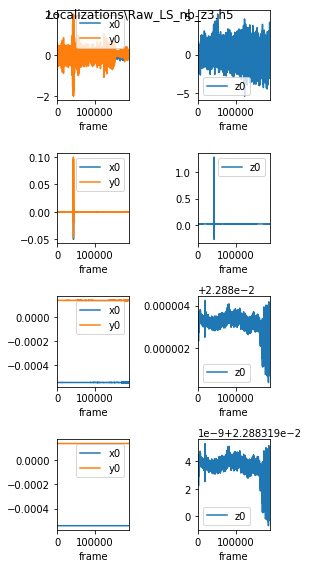

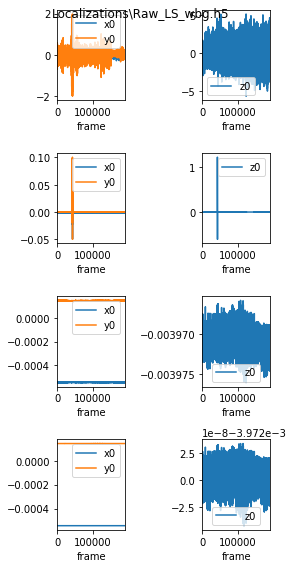

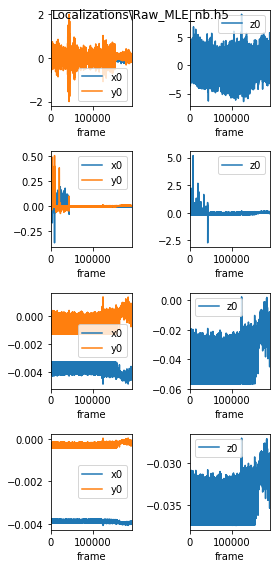

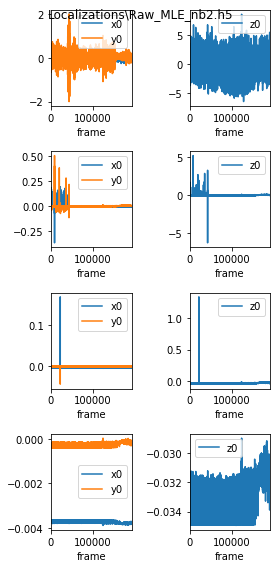

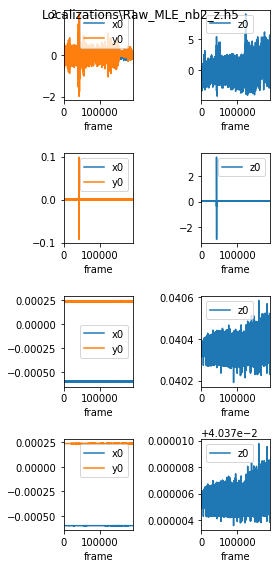

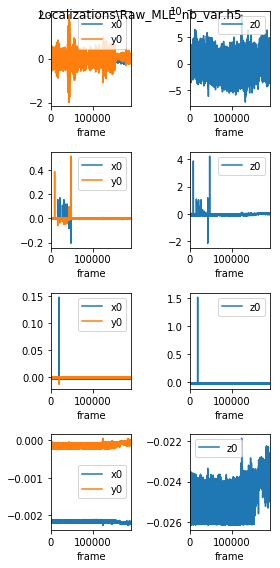

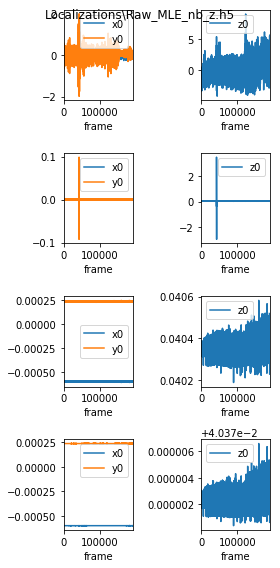

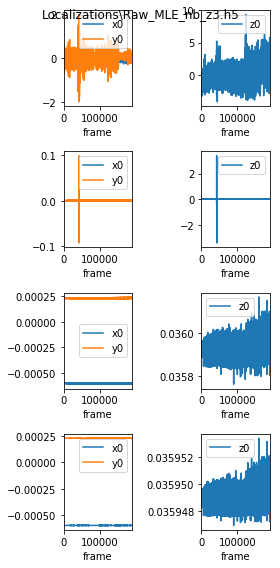

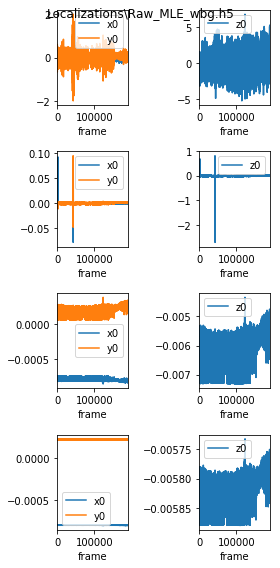

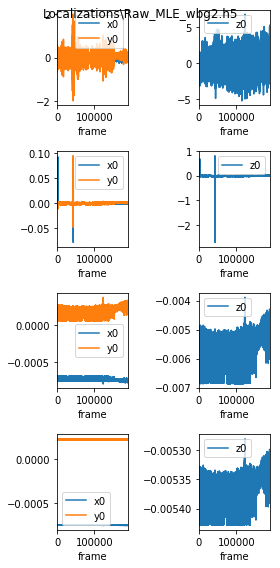

In [243]:
data_dc2 = {}
for k, v in data_dc.items():
    v = v[abs(v.z0) < 20]
    fig, axs = plt.subplots(4, 2, figsize=(4, 8))
    for (ax_xy, ax_z), r in zip(axs[:3], (2, 2, 2)):
        corr_fids = extract_fiducials(v, good_fid[["y0","x0"]].values, r)
        corr_drift = calc_drift(corr_fids)
        corr_drift[["x0", "y0"]].plot(ax=ax_xy)
        corr_drift[["z0"]].plot(ax=ax_z)
        data_dc2[k] = v = remove_drift(v, corr_drift)
#         break
    corr_drift2=calc_drift(extract_fiducials(v, good_fid[["y0","x0"]].values, r))
    corr_drift2[["x0", "y0"]].plot(ax=axs[-1, 0])
    corr_drift2[["z0"]].plot(ax=axs[-1, 1])
    fig.suptitle(k)
    fig.tight_layout()
#     break

In [248]:
import seaborn as sns
sns.set()

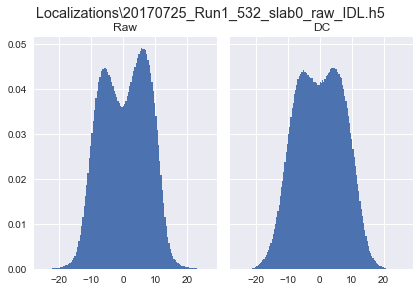

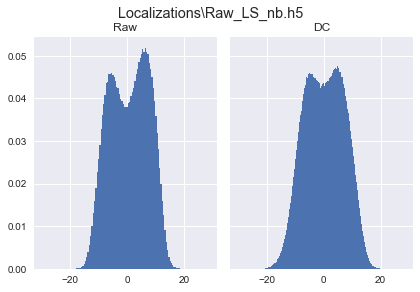

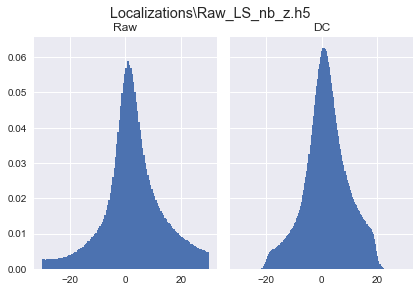

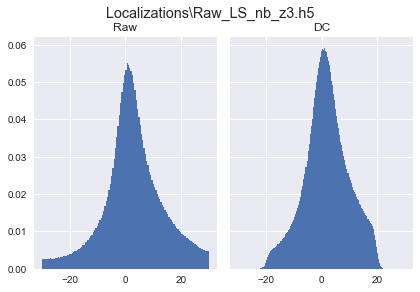

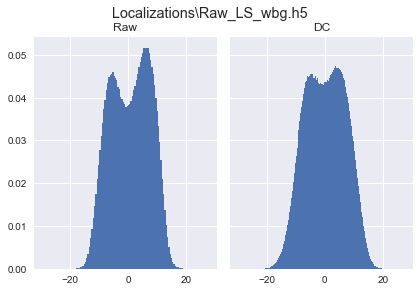

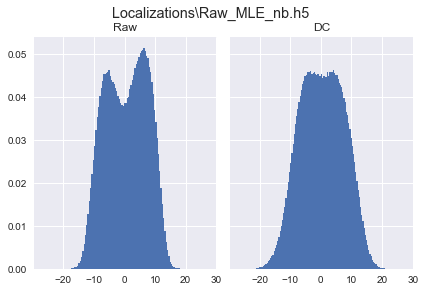

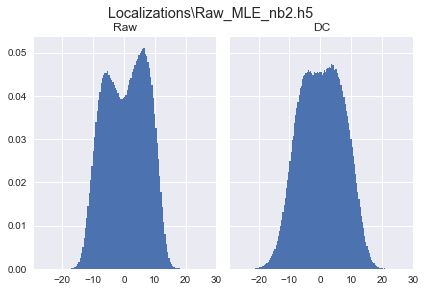

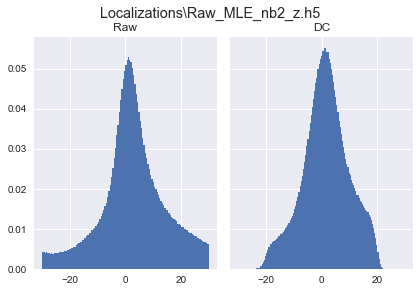

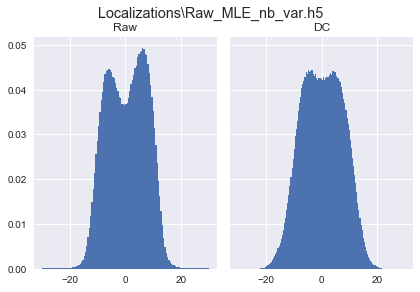

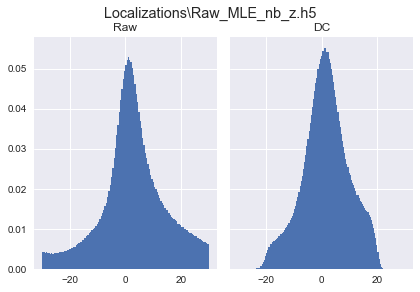

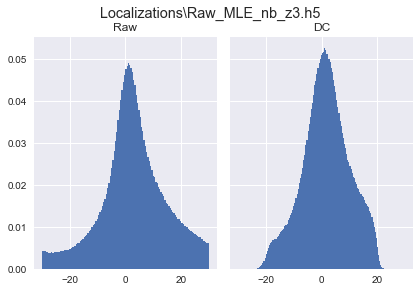

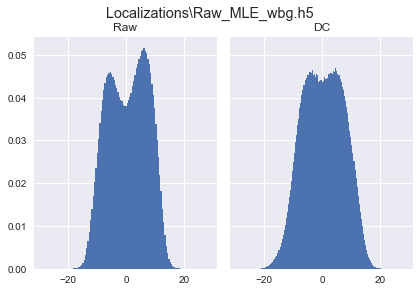

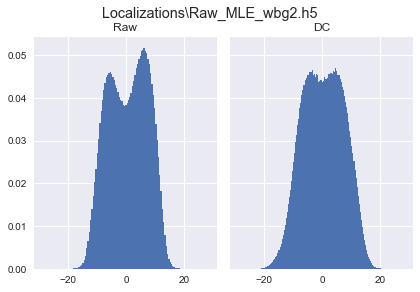

In [249]:
for k, v in data_dict.items():
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    for ax, d, t in zip(axs.ravel(), (v, data_dc2[k]), ("Raw", "DC")):
        d = d[(d.x0 < 512-200) & (d.x0 > 200) & (d.y0 < 512-200) & (d.y0 > 200)]
        d.z0.hist(ax=ax, normed=True, bins=128)
        ax.set_title(t)
    fig.suptitle(k, y=1.01)
    fig.tight_layout()

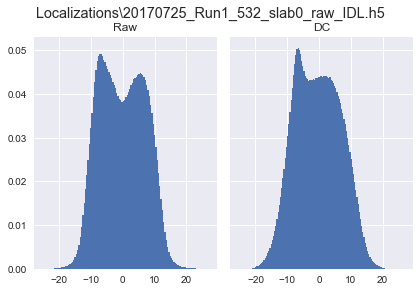

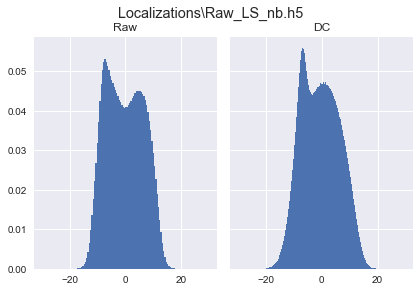

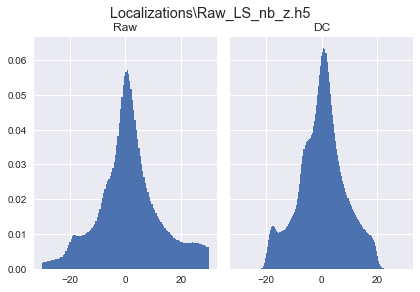

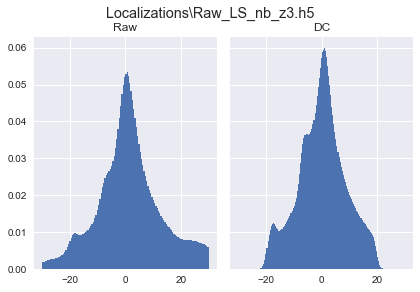

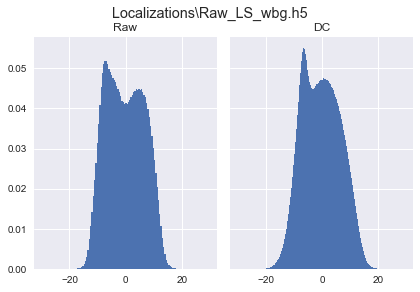

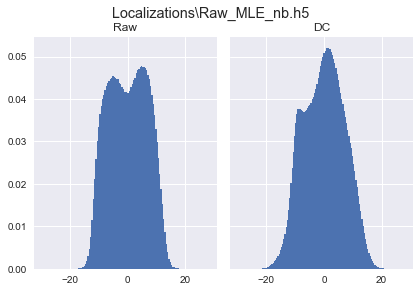

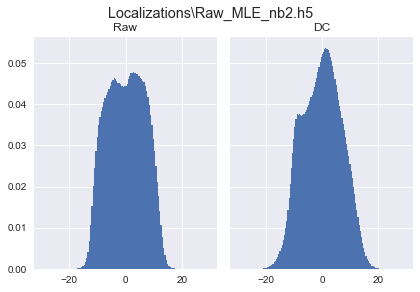

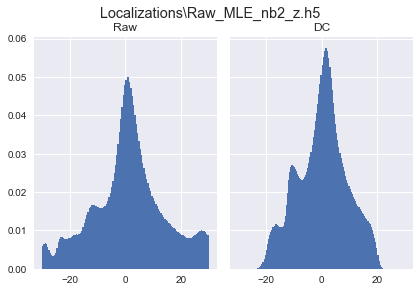

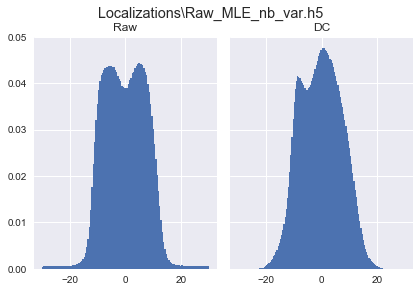

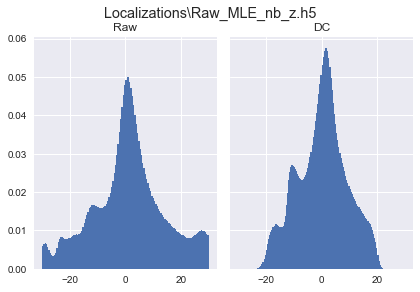

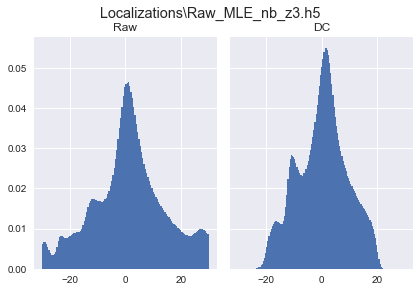

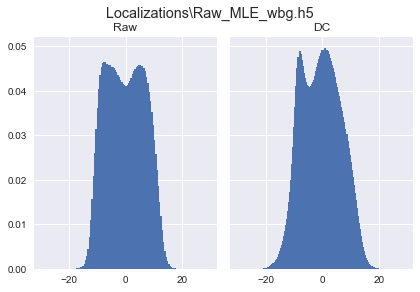

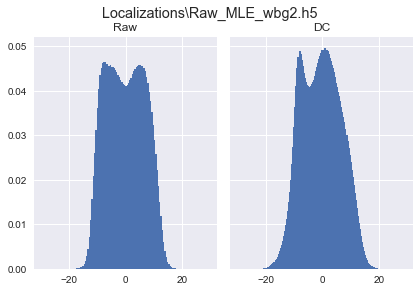

In [250]:
for k, v in data_dict.items():
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    for ax, d, t in zip(axs.ravel(), (v, data_dc2[k]), ("Raw", "DC")):
        d.z0.hist(ax=ax, normed=True, bins=128)
        ax.set_title(t)
    fig.suptitle(k, y=1.01)
    fig.tight_layout()

In [246]:
stats_dc2 = {}
for k, v in data_dc2.items():
    fid_stats, all_drift = calc_fiducial_stats(extract_fiducials(v, good_fid[["y0","x0"]].values, 1))
    stats_dc2[k] = dict(fid_stats=fid_stats, all_drift=all_drift)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Localizations\20170725_Run1_532_slab0_raw_IDL.h5
x0     15.44474
y0     14.77981
z0    190.68655
dtype: float64
Localizations\Raw_LS_nb.h5
x0     15.317213
y0     14.665841
z0    188.589089
dtype: float64
Localizations\Raw_LS_nb_z.h5
x0     15.249591
y0     14.425771
z0    141.464604
dtype: float64
Localizations\Raw_LS_nb_z3.h5
x0     15.246989
y0     14.422605
z0    144.966794
dtype: float64
Localizations\Raw_LS_wbg.h5
x0     15.415577
y0     14.759437
z0    190.351499
dtype: float64
Localizations\Raw_MLE_nb.h5
x0     16.034256
y0     14.861325
z0    177.877310
dtype: float64
Localizations\Raw_MLE_nb2.h5
x0     18.628105
y0     17.453634
z0    188.245388
dtype: float64
Localizations\Raw_MLE_nb2_z.h5
x0     15.024438
y0     13.505749
z0    139.175998
dtype: float64
Localizations\Raw_MLE_nb_var.h5
x0     16.099649
y0     14.765405
z0    200.196066
dtype: float64
Localizations\Raw_MLE_nb_z.h5
x0     15.024767
y0     13.505748
z0    139.180725
dtype: float64
Localizations\Raw_MLE_nb_z3.h5

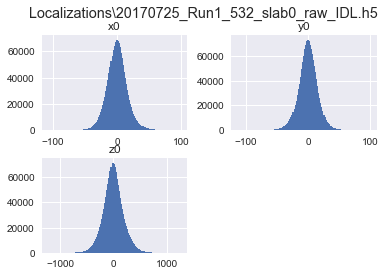

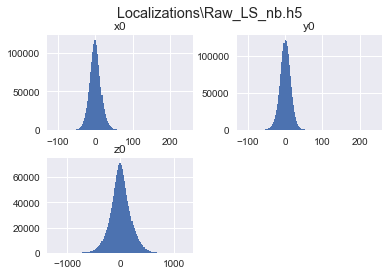

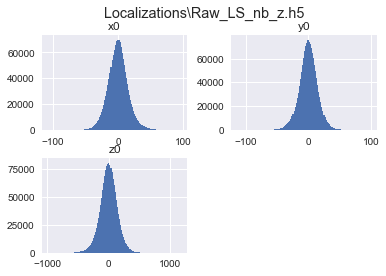

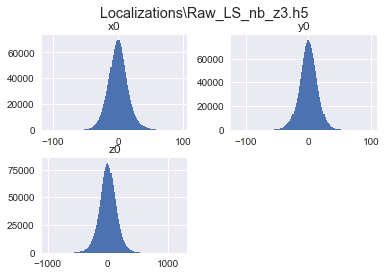

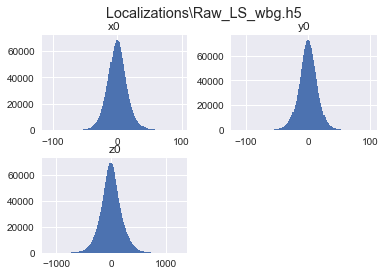

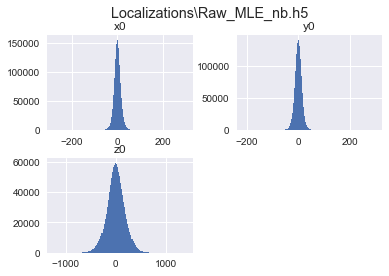

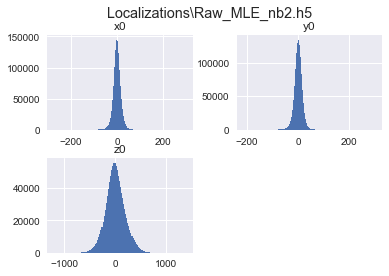

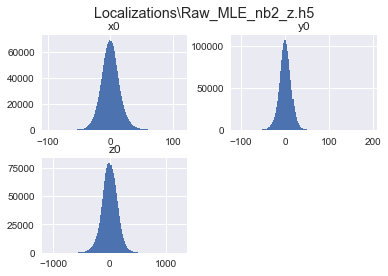

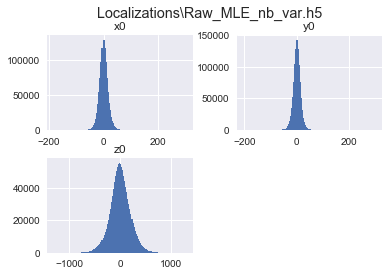

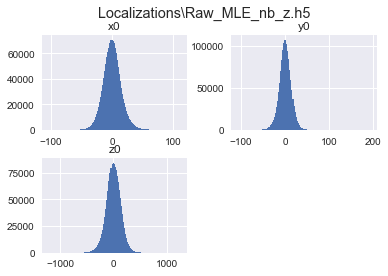

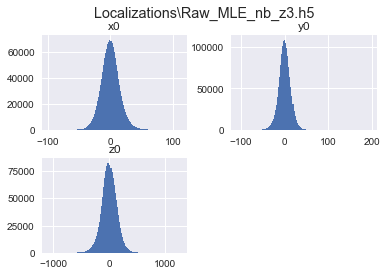

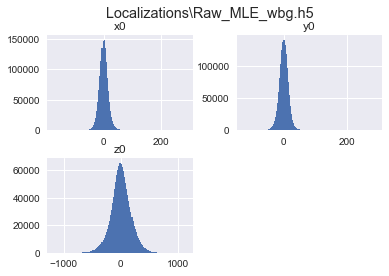

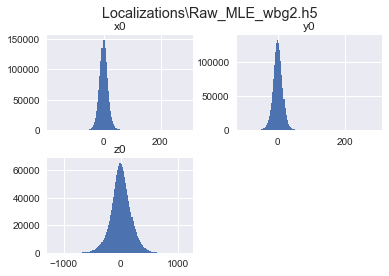

In [251]:
for k, v in sorted(stats_dc2.items()):
    print(k)
    print(v["all_drift"].std() * 2 * np.sqrt(2 * np.log(2)) * np.array((130, 130, 20 * 1.54)))
    (v["all_drift"] * 2 * np.sqrt(2 * np.log(2)) * np.array((130, 130, 20 * 1.54))).hist(bins=128)
    plt.suptitle(k)

In [228]:
for k, v in data_dc2.items():
    v.to_hdf(k, "dc")

In [71]:
v.to_hdf(k, "dc")